<>:143: SyntaxWarning: invalid escape sequence '\k'
<>:143: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_804391/2128352114.py:143: SyntaxWarning: invalid escape sequence '\k'
  plt.title(f'Bias (d={d}, $\kappa$={kappa})')


Running Scaling Experiment: d=10, kappa=1.0
Scaling Ridge by d (10.0) to match EK spectrum.
------------------------------------------------------------
P      | N      | Bias Th   | Bias Emp  | Var Th    | Var Emp  
------------------------------------------------------------
0.10   | 1      | 0.9803    | 1.0439    | 0.0990    | 0.0015   
0.22   | 2      | 0.9583    | 0.9500    | 0.0979    | 0.0034   
0.46   | 4      | 0.9133    | 0.9956    | 0.0956    | 0.0056   
1.00   | 10     | 0.8264    | 0.7968    | 0.0909    | 0.0120   
2.15   | 21     | 0.6769    | 0.6768    | 0.0823    | 0.0224   
4.64   | 46     | 0.4665    | 0.4891    | 0.0683    | 0.0316   
10.00  | 100    | 0.2500    | 0.2552    | 0.0500    | 0.0287   
21.54  | 215    | 0.1005    | 0.1055    | 0.0317    | 0.0232   
46.42  | 464    | 0.0314    | 0.0330    | 0.0177    | 0.0147   
100.00 | 1000   | 0.0083    | 0.0070    | 0.0091    | 0.0087   


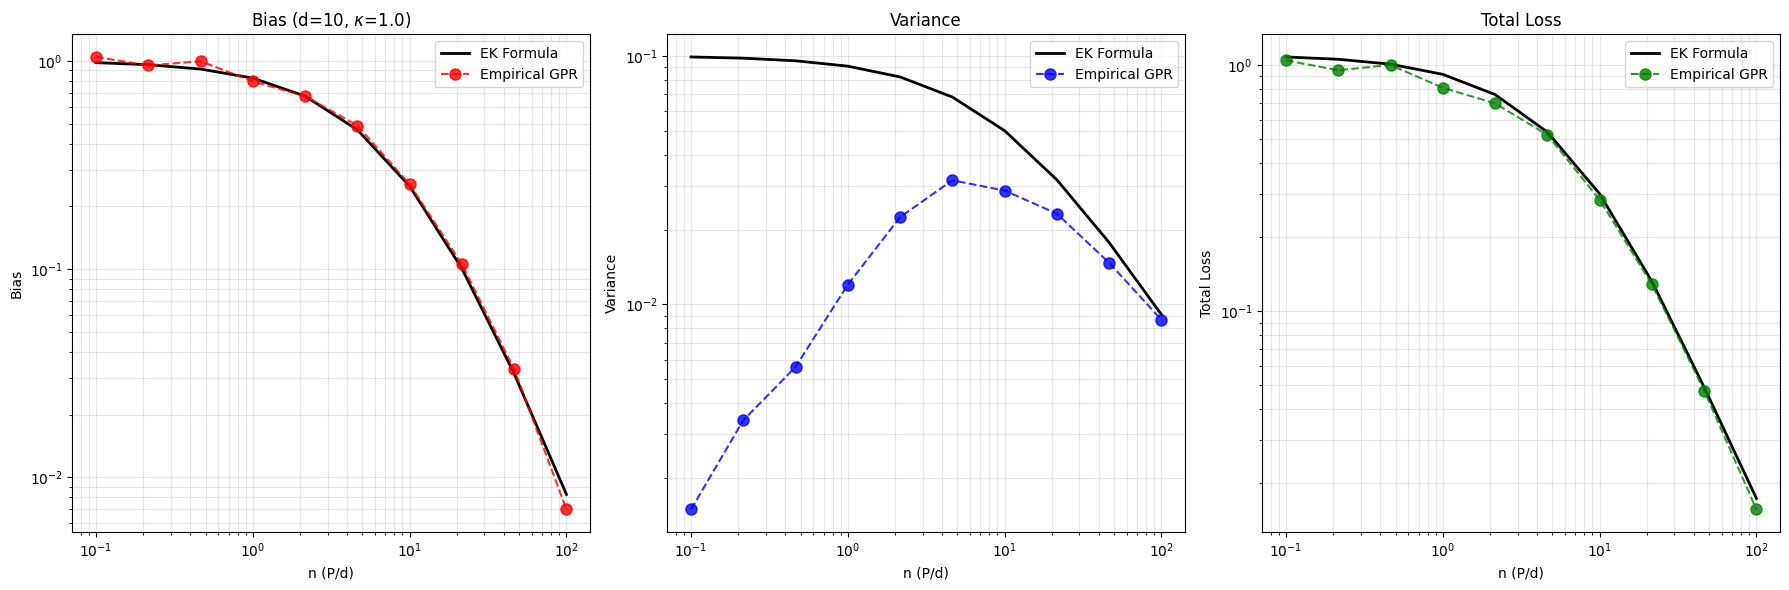

In [ ]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. Definitions
# ==========================================

def compute_theoretical_loss(d, P, kappa):
    """
    Theoretical EK Loss based on user formula.
    """
    lH = 1.0 / d
    
    denom = lH + (kappa / P)
    
    # User's formula
    # Note: These represent the summed risk over d dimensions
    # assuming the formulas provided were already the total risk
    # or the risk for a unit target vector.
    bias_theo = ((kappa / P) / denom) ** 2
    var_theo = (kappa / P) * (lH / denom)
    
    return bias_theo, var_theo

def kernel_fn(X1, X2, d):
    """Linear Kernel normalized by d."""
    return (X1 @ X2.T) / d

def run_empirical_simulation(d, n, kappa, n_trials=30, n_test=1000):
    """
    Runs GPR simulation.
    CRITICAL CHANGE: The ridge parameter is scaled by d to match 
    the signal-to-noise ratio of the EK formula.
    """
    P = int(n * d)
    
    # 1. Teacher / Ground Truth (Unit vector)
    w_star = np.random.randn(d)
    w_star /= np.linalg.norm(w_star)
    
    # 2. Test Set
    X_test = np.random.randn(n_test, d)
    f_test = X_test @ w_star 
    
    predictions = np.zeros((n_trials, n_test))
    
    for i in range(n_trials):
        # A. Train Data
        X_train = np.random.randn(P, d)
        
        # Noise variance is set to kappa
        noise = np.random.randn(P) * np.sqrt(kappa)
        y_train = X_train @ w_star + noise
        
        # B. Kernel Matrix
        # Eigenvalues of K_train sum to N. Non-zero eigs are approx P.
        K_train = kernel_fn(X_train, X_train, d)
        
        # C. Solve with SCALED Ridge
        # Theory SNR: P / (d*kappa)
        # Sim SNR:    P / lambda
        # Therefore:  lambda = kappa * d
        effective_ridge = kappa * d
        
        reg_matrix = K_train + effective_ridge * np.eye(P)
        
        try:
            c, lower = scipy.linalg.cho_factor(reg_matrix)
            alpha = scipy.linalg.cho_solve((c, lower), y_train)
        except:
            alpha = scipy.linalg.solve(reg_matrix, y_train, assume_a='pos')
        
        # D. Predict
        K_test = kernel_fn(X_test, X_train, d)
        predictions[i, :] = K_test @ alpha

    # 3. Compute Metrics
    f_bar = np.mean(predictions, axis=0)
    
    # Bias: Error of the mean predictor
    bias_emp = np.mean((f_bar - f_test)**2)
    
    # Variance: Average variance of predictors around mean
    var_emp = np.mean(np.var(predictions, axis=0))
    
    return bias_emp, var_emp

# ==========================================
# 2. Experiment Setup
# ==========================================

# Fixed Parameters
d = 10            # Dimension
kappa = 1.0        # Noise Variance / Base Regularization parameter
n_trials = 50      # Averaging trials

# We vary P to see the learning curve
# Covering under-parameterized (P<1) to over-parameterized (P>1)
n_values = np.logspace(np.log10(0.1), np.log10(100.0), 10)

results = {
    'n': n_values,
    'bias_th': [], 'var_th': [], 'loss_th': [],
    'bias_emp': [], 'var_emp': [], 'loss_emp': []
}

print(f"Running Scaling Experiment: d={d}, kappa={kappa}")
print(f"Scaling Ridge by d ({kappa*d}) to match EK spectrum.")
print("-" * 60)
print(f"{'n':<6} | {'P':<6} | {'Bias Th':<9} | {'Bias Emp':<9} | {'Var Th':<9} | {'Var Emp':<9}")
print("-" * 60)

for n in n_values:
    # Theory
    b_th, v_th = compute_theoretical_loss(d, n, kappa)
    
    # Empirical
    b_emp, v_emp = run_empirical_simulation(d, n, kappa, n_trials=n_trials)
    
    results['bias_th'].append(b_th)
    results['var_th'].append(v_th)
    results['loss_th'].append(b_th + v_th)
    results['bias_emp'].append(b_emp)
    results['var_emp'].append(v_emp)
    results['loss_emp'].append(b_emp + v_emp)
    
    print(f"{n:<6.2f} | {int(n*d):<6} | {b_th:<9.4f} | {b_emp:<9.4f} | {v_th:<9.4f} | {v_emp:<9.4f}")

# ==========================================
# 3. Plotting
# ==========================================

plt.figure(figsize=(18, 6))

# Bias
plt.subplot(1, 3, 1)
plt.loglog(results['n'], results['bias_th'], 'k-', lw=2, label='EK Formula')
plt.loglog(results['n'], results['bias_emp'], 'ro--', markersize=8, label='Empirical GPR', alpha=0.8)
plt.xlabel('n (P/d)')
plt.ylabel('Bias')
plt.title(f'Bias (d={d}, $\kappa$={kappa})')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Variance
plt.subplot(1, 3, 2)
plt.loglog(results['n'], results['var_th'], 'k-', lw=2, label='EK Formula')
plt.loglog(results['n'], results['var_emp'], 'bo--', markersize=8, label='Empirical GPR', alpha=0.8)
plt.xlabel('n (P/d)')
plt.ylabel('Variance')
plt.title(f'Variance')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Total Loss
plt.subplot(1, 3, 3)
plt.loglog(results['n'], results['loss_th'], 'k-', lw=2, label='EK Formula')
plt.loglog(results['n'], results['loss_emp'], 'go--', markersize=8, label='Empirical GPR', alpha=0.8)
plt.xlabel('n (P/d)')
plt.ylabel('Total Loss')
plt.title(f'Total Loss')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()